[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ds-reboot/python-first-part/blob/main/notebooks/hometasks/Task3_dmrf_OOP.ipynb)

# Задание
Реализовать с помощью объектно-ориентированного подхода предыдущие 2 задания. Создайте для каждой из задач отдельный класс, который позволяет ее решить.

* Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф"
* Cохранить ее в pandas dataframe, а также в excel, pickle, БД

* Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных

*  Сделать визуализацию для мини-исследования рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.



In [9]:
import requests

## Класс для загрузки объектов

In [44]:
class Loader:
    def __init__(self):
        self.url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset=0&limit=1&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
        self.total = int(requests.get(self.url).json().get('data').get('total'))
        print(f'Total count: {self.total}')
        self.offset_ = 0
        self.limit_ = 100
        self.objects_list = []

    def get_buildings_data(self):
        self.offset_ = 0
        from tqdm import tqdm
        with tqdm(total=100, postfix=["Offset:", dict(value=0)]) as pbar:
            while self.offset_ < self.total:
                url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={self.offset_}&limit={self.limit_}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
                res = requests.get(url)
                request_list = res.json().get('data').get('list')
                if request_list:
                    self.offset_ += self.limit_
                    self.objects_list.extend(request_list)
                    if len(request_list) == 0:
                        break
                    pbar.postfix[1]["value"] = self.offset_
                    pbar.n = round(self.offset_/self.total*100)
                    pbar.refresh()
                else:
                    print(f"Retry, offset: {self.offset_}")
        return self.objects_list

    def get_object_data(self, obj_id):
        url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{obj_id}'
        res = requests.get(url)
        data = res.json().get('data')
        return data

    def show_ids(self):
        pass


## Обогащение датасета

In [ ]:
import pandas as pd
from pandas import DataFrame as df
loader = Loader()
buildings_data = df.from_dict(loader.get_buildings_data(), orient='columns')
buildings_data

In [ ]:
def data_enrichment(oid):
    try:
        res = loader.get_object_data(oid)
        additional_info = df.from_dict(res, orient='index')
        t = additional_info.transpose()
        return t.squeeze()
    except Exception as e:
        print(str(e), oid)
from tqdm import tqdm
tqdm.pandas(desc='Progress:')
applied_df = buildings_data.progress_apply(lambda row: data_enrichment(row.objId), axis='columns', result_type='expand')

In [129]:
import seaborn as sns
import numpy as np

In [150]:
## Класс для сохранения данных

In [132]:
class Saver:
    def __init__(self, data):
        self.data = data

    def to_pickle(self, name=None):
        if name is None:
            name = 'file.pkl'
        self.data.to_pickle(name)

    def to_csv(self, name=None):
        if name is None:
            name = 'file.csv'
        self.data.to_csv(name, index=False)

    def to_xls(self, name=None):
        if name is None:
            name = 'file.xlsx'
        self.data.to_excel(name, index=False)

    def to_sql(self, db_name=None, table_name=None):
        import sqlite3
        if db_name is None:
            db_name='db_name'
        if table_name is None:
            table_name='table_name'
        conn = sqlite3.connect(db_name)
        self.data.to_sql(table_name, conn, if_exists='replace', index = False)
        conn.commit()
        conn.close()


In [ ]:
saver = Saver(applied_df)
saver.to_csv()

In [144]:
## Класс для визуализации

In [172]:
class Visualizer:
    def __init__(self,data):
        import seaborn as sns
        self.sns = sns
        self.data = data

    def make_boxplot(self, x, y, hue=None):
        self.sns.barplot(data=self.data,
            x=x,
            y=y,
            hue=hue)
    def make_heatmap(self, region=None):
        if region is not None:
            d = self.data[self.data["Регион"] == region]
            self.sns.heatmap(d.corr())
        else:
            self.sns.heatmap(self.data.corr())

In [ ]:
# "Мини-исследование.Выбираем параметры из датасета и ислледуем их корреляцию между собой."

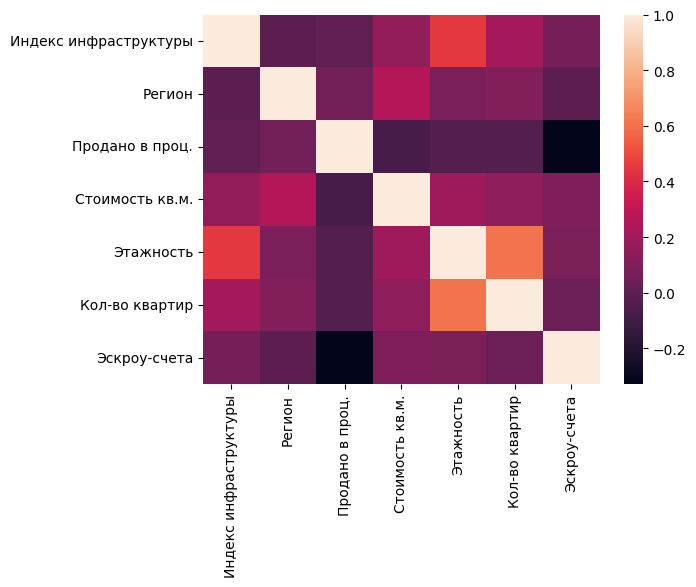

In [192]:
import warnings
warnings.filterwarnings('ignore')

new_data = applied_df[["infrastructureIndexValue", "region", "soldOutPerc", "objPriceAvg", "floorMax", "objFlatCnt",
                       "objGuarantyEscrowFlg","objLkClassDesc", "objLkLatitude"]]
new_data.rename(columns = {'infrastructureIndexValue' : 'Индекс инфраструктуры',
                           'region' : 'Регион',
                           "soldOutPerc" : 'Продано в проц.',
                           "objPriceAvg" : 'Стоимость кв.м.',
                           "floorMax": 'Этажность',
                           "objFlatCnt": 'Кол-во квартир',
                           "objGuarantyEscrowFlg": "Эскроу-счета",
                           "objLkLatitude": "Географическая широта"
                           }, inplace = True)

visualiser = Visualizer(new_data)
visualiser.make_heatmap()

In [181]:
# "В целом по России заметна зависимость цены новостройки от региона и стремление строить как можно больше там где лучше инфраструктура"

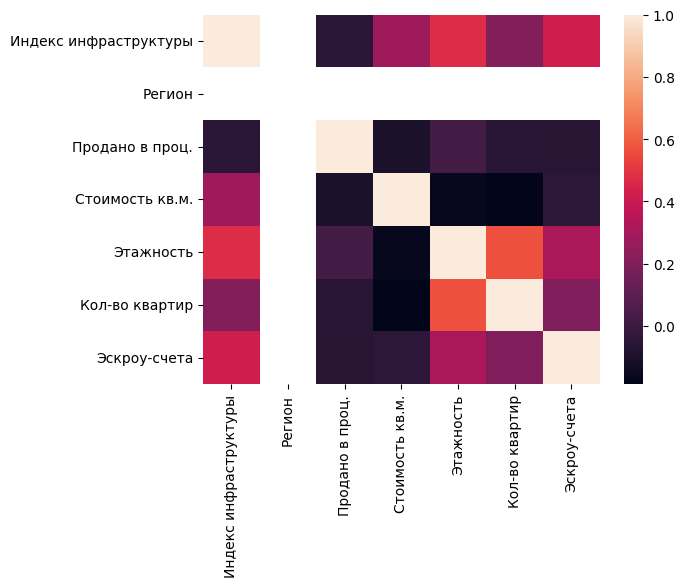

In [193]:
visualiser.make_heatmap(region=77)

# "В Москве правит бал индекс инфраструктуры"

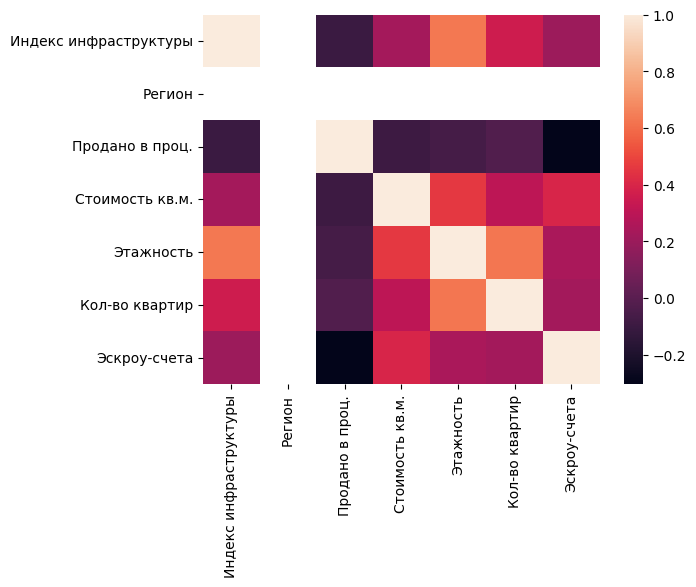

In [182]:
visualiser.make_heatmap(region=50)

# "В Подмосковье более четко видна зависимость цены от этажности"

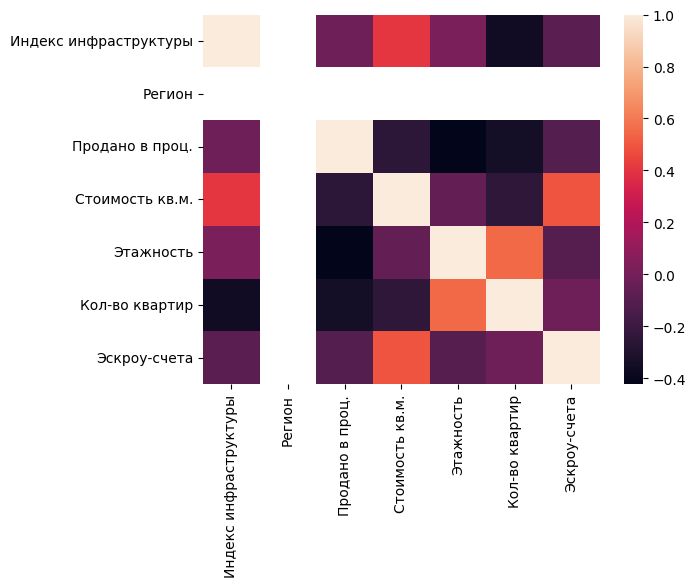

In [187]:
visualiser.make_heatmap(region=43)

# "В Кировской области цены зависят, в основном, от работы застройщика через эскроу-счета"

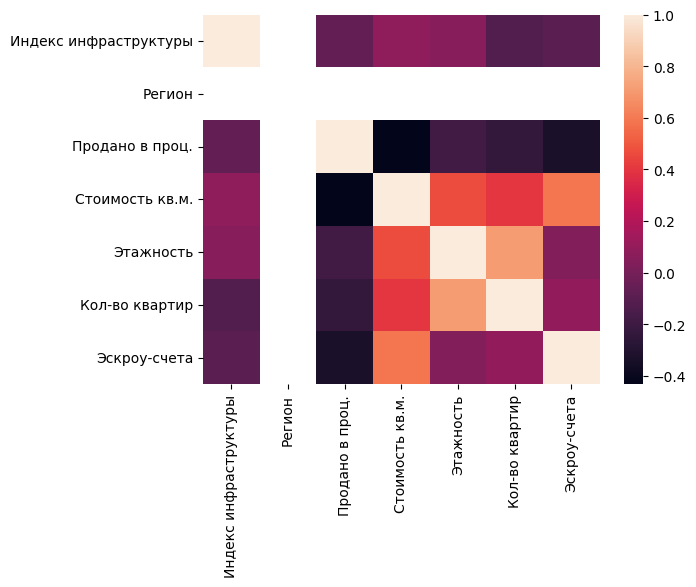

In [190]:
visualiser.make_heatmap(region=22)

# "в Алтайском крае стоимость сильнее зависит от этажности"